In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn import tree
from sklearn import metrics
import os
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

### Reading Training data

In [2]:
df1=pd.read_csv("./processed/training/engaged.csv")
df2=pd.read_csv("./processed/training/notEngaged.csv")
dff=pd.read_csv("./TopFeatures.csv")

In [3]:
dft=pd.concat([df1,df2])

In [4]:
feat=dff.to_numpy()
feat=feat.reshape(-1)

In [5]:
print(feat)

[' AU12_c' ' AU04_c' ' AU12_r' ' AU04_r' ' AU05_c' ' AU14_c' ' AU06_c'
 ' AU06_r' ' AU14_r' ' AU07_r' ' p_8' ' AU10_c' ' p_2' ' AU10_r' ' p_0'
 ' p_23' ' p_7' ' p_6' ' p_10' ' AU01_r' ' AU25_r' ' p_24' ' p_12' ' p_11'
 ' AU17_r' ' AU09_r' ' AU26_r' ' p_9' ' AU45_r' ' p_20' ' AU05_r'
 ' AU23_r' ' p_13' ' p_19' ' p_33' ' gaze_angle_y' ' p_5' ' AU02_r'
 ' p_26' ' p_18' ' p_16' ' gaze_1_y' ' p_32' ' AU07_c' ' AU15_c' ' AU15_r'
 ' p_30' ' p_31' ' AU20_r' ' p_4']


In [6]:
y_train=dft["Result"]
x_train=dft.drop("Result",axis=1)
x_train=x_train[feat]

In [7]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt



## Hyper Parameter tuning

### Evaluating testing with 10 folds validation

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

def dtree_grid_search(X,y,nfolds):
    #create a dictionary of all values we want to test
    param_grid = { 'criterion':['gini','entropy'],
                  'max_depth': np.arange(1, 6),
                  'min_samples_leaf':np.arange(1,5),
                  'min_samples_split':np.arange(2,5)}
    # decision tree model
    dtree_model=tree.DecisionTreeClassifier()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds)
    #fit model to data
    dtree_gscv.fit(X, y)
    return dtree_gscv.best_params_,dtree_gscv.cv_results_

In [9]:
best_score,all_score=dtree_grid_search(x_train,y_train,10)

listDf=pd.DataFrame(all_score)
listDf=listDf[["params","mean_test_score"]]

print(listDf)


                                                params  mean_test_score
0    {'criterion': 'gini', 'max_depth': 1, 'min_sam...         0.600441
1    {'criterion': 'gini', 'max_depth': 1, 'min_sam...         0.600441
2    {'criterion': 'gini', 'max_depth': 1, 'min_sam...         0.600441
3    {'criterion': 'gini', 'max_depth': 1, 'min_sam...         0.600441
4    {'criterion': 'gini', 'max_depth': 1, 'min_sam...         0.600441
..                                                 ...              ...
115  {'criterion': 'entropy', 'max_depth': 5, 'min_...         0.684757
116  {'criterion': 'entropy', 'max_depth': 5, 'min_...         0.684802
117  {'criterion': 'entropy', 'max_depth': 5, 'min_...         0.684666
118  {'criterion': 'entropy', 'max_depth': 5, 'min_...         0.684938
119  {'criterion': 'entropy', 'max_depth': 5, 'min_...         0.684848

[120 rows x 2 columns]


### Getting Best Parameters

In [10]:
print(best_score)

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 4}


### Initialize model with optimum parameters

In [11]:
model = tree.DecisionTreeClassifier(max_depth=5,criterion='gini',min_samples_leaf=2,min_samples_split=4)

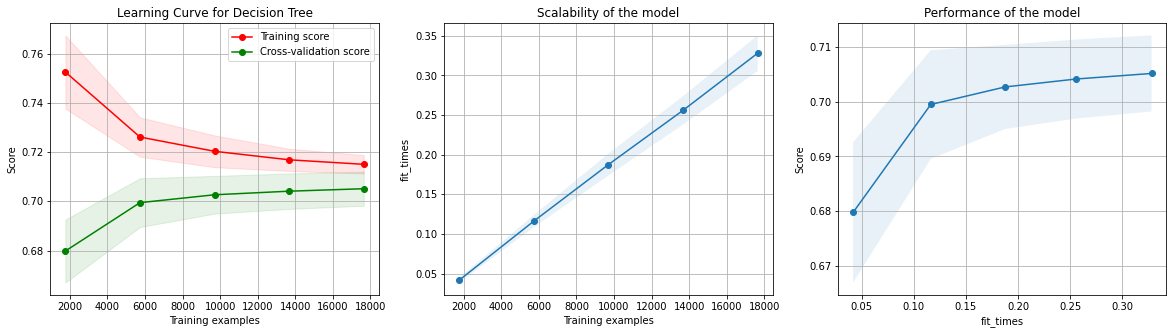

In [12]:
#fig, axes = plt.subplots(3, 1, figsize=(10, 15))


# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)


title = "Learning Curve for Decision Tree"
estimator = model
plot_learning_curve(estimator, title, x_train, y_train,
                    cv=cv, n_jobs=4)
plt.show()
plt.close()
    

### Score of the model with 100 folds

In [13]:
avg_score=cross_val_score(model,x_train, y_train, cv=100)

In [14]:
print(avg_score)
print(sum(avg_score)/100)

[0.76923077 0.69230769 0.69683258 0.74208145 0.73755656 0.65158371
 0.75565611 0.78733032 0.74660633 0.760181   0.6561086  0.73303167
 0.74660633 0.76923077 0.71040724 0.71493213 0.7918552  0.81900452
 0.77828054 0.81900452 0.71493213 0.70588235 0.70135747 0.61538462
 0.69683258 0.5520362  0.57013575 0.62443439 0.60180995 0.6199095
 0.56561086 0.54751131 0.58371041 0.58823529 0.60633484 0.57466063
 0.58371041 0.61538462 0.59276018 0.54751131 0.50678733 0.59728507
 0.41628959 0.52488688 0.53846154 0.52941176 0.55656109 0.53393665
 0.63348416 0.52036199 0.53846154 0.61538462 0.58371041 0.58823529
 0.59276018 0.68636364 0.76363636 0.76363636 0.76363636 0.67727273
 0.76363636 0.75454545 0.76818182 0.80454545 0.72727273 0.84545455
 0.72727273 0.77272727 0.8        0.73636364 0.80909091 0.76818182
 0.76363636 0.80454545 0.82727273 0.72727273 0.73636364 0.76818182
 0.78636364 0.79545455 0.77272727 0.77272727 0.81363636 0.86818182
 0.91818182 0.9        0.68181818 0.67727273 0.73636364 0.80454

### Training of the given model

In [15]:
model = model.fit(x_train, y_train)

In [16]:
target_names = ['Not Engaged','Engaged']
claf_report=classification_report(y_train,model.predict(x_train),target_names=target_names,output_dict=True)
print(claf_report)

{'Not Engaged': {'precision': 0.6897204120243852, 'recall': 0.6672767947935733, 'f1-score': 0.6783130039280545, 'support': 9834}, 'Engaged': {'precision': 0.7390957658878877, 'recall': 0.7584485721299402, 'f1-score': 0.7486471205879976, 'support': 12221}, 'accuracy': 0.7177964180457946, 'macro avg': {'precision': 0.7144080889561364, 'recall': 0.7128626834617567, 'f1-score': 0.7134800622580261, 'support': 22055}, 'weighted avg': {'precision': 0.7170800220704456, 'recall': 0.7177964180457946, 'f1-score': 0.7172861728104469, 'support': 22055}}


In [17]:
helix=pd.read_csv("./TopFeatures.csv")
h2=pd.read_csv("./heatMaps.csv")
helix['value']=h2
#print(helix)
helix.to_csv("Finalmaps.csv",index=None,header=None)

g1=pd.read_csv("./Finalmaps.csv",index_col=None)
h6=helix['value'].to_numpy()
h6=np.reshape(h6, (50, 1)) # C-like index ordering
#print(h6)

## HeatMap

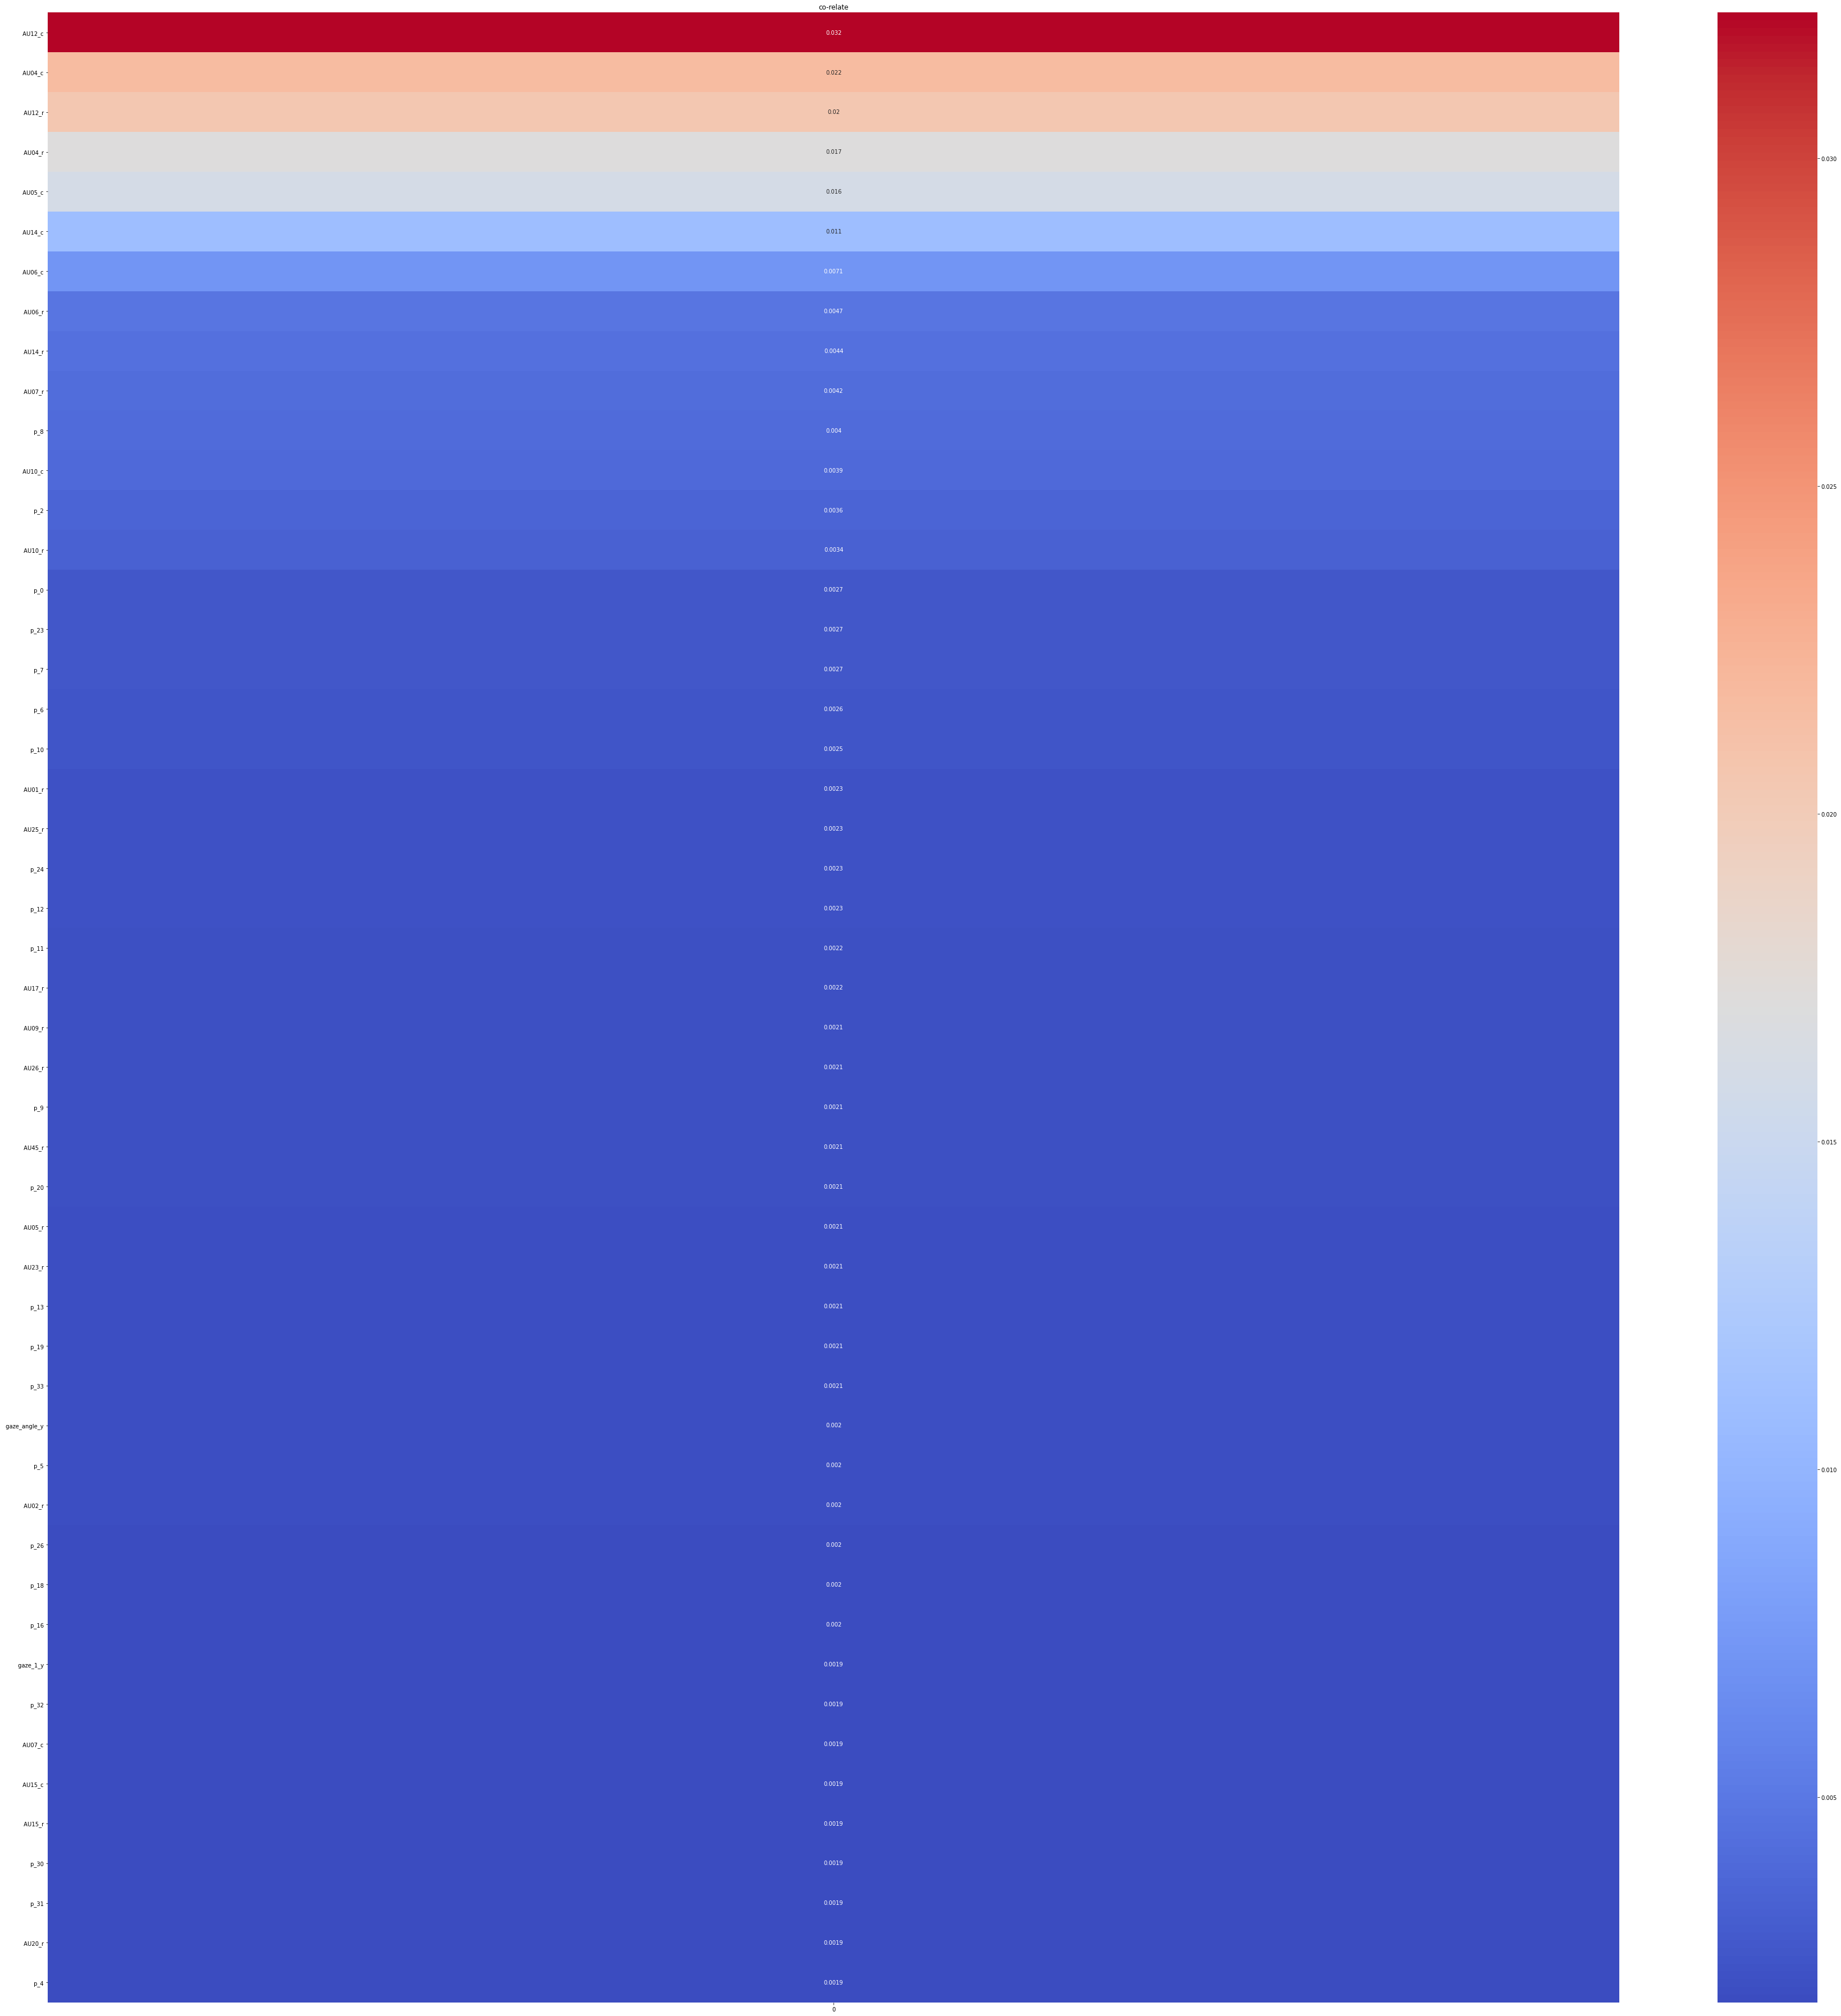

In [18]:
plt.figure(figsize=(50,50))

ax=sns.heatmap(h6, annot=True, cmap="coolwarm", yticklabels=helix['0']).set_title('co-relate')
plt.tight_layout()
plt.show()

<AxesSubplot:>

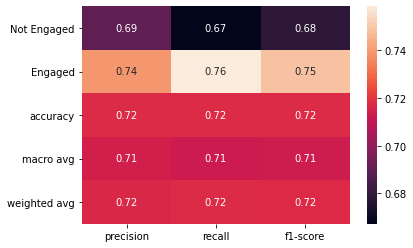

In [19]:
sns.heatmap(pd.DataFrame(claf_report).iloc[:-1, :].T, annot=True)

### Saving the Model

In [20]:
patho=r'./models'
joblib.dump(model, (os.path.join(patho,r''+'model_joblib_decision_tree')))

['./models/model_joblib_decision_tree']

In [21]:
plt.close()

In [22]:
tree.export_graphviz(model,
                     out_file="tree.dot",
                     feature_names = feat, 
                     class_names=["Not Engaged","Engaged"],
                     filled = True)

[Text(1255.5, 2491.5, ' AU12_r <= 0.475\ngini = 0.494\nsamples = 22055\nvalue = [9834, 12221]\nclass = Engaged'),
 Text(627.75, 2038.5, ' AU04_r <= 0.235\ngini = 0.498\nsamples = 17093\nvalue = [9107, 7986]\nclass = Not Engaged'),
 Text(313.875, 1585.5, ' AU05_c <= 0.5\ngini = 0.489\nsamples = 9874\nvalue = [4212, 5662]\nclass = Engaged'),
 Text(156.9375, 1132.5, ' AU12_c <= 0.5\ngini = 0.5\nsamples = 7469\nvalue = [3662, 3807]\nclass = Engaged'),
 Text(78.46875, 679.5, ' AU04_r <= 0.035\ngini = 0.5\nsamples = 7222\nvalue = [3646, 3576]\nclass = Not Engaged'),
 Text(39.234375, 226.5, 'gini = 0.496\nsamples = 4667\nvalue = [2115, 2552]\nclass = Engaged'),
 Text(117.703125, 226.5, 'gini = 0.48\nsamples = 2555\nvalue = [1531, 1024]\nclass = Not Engaged'),
 Text(235.40625, 679.5, ' AU09_r <= 0.52\ngini = 0.121\nsamples = 247\nvalue = [16, 231]\nclass = Engaged'),
 Text(196.171875, 226.5, 'gini = 0.102\nsamples = 242\nvalue = [13, 229]\nclass = Engaged'),
 Text(274.640625, 226.5, 'gini = 0.

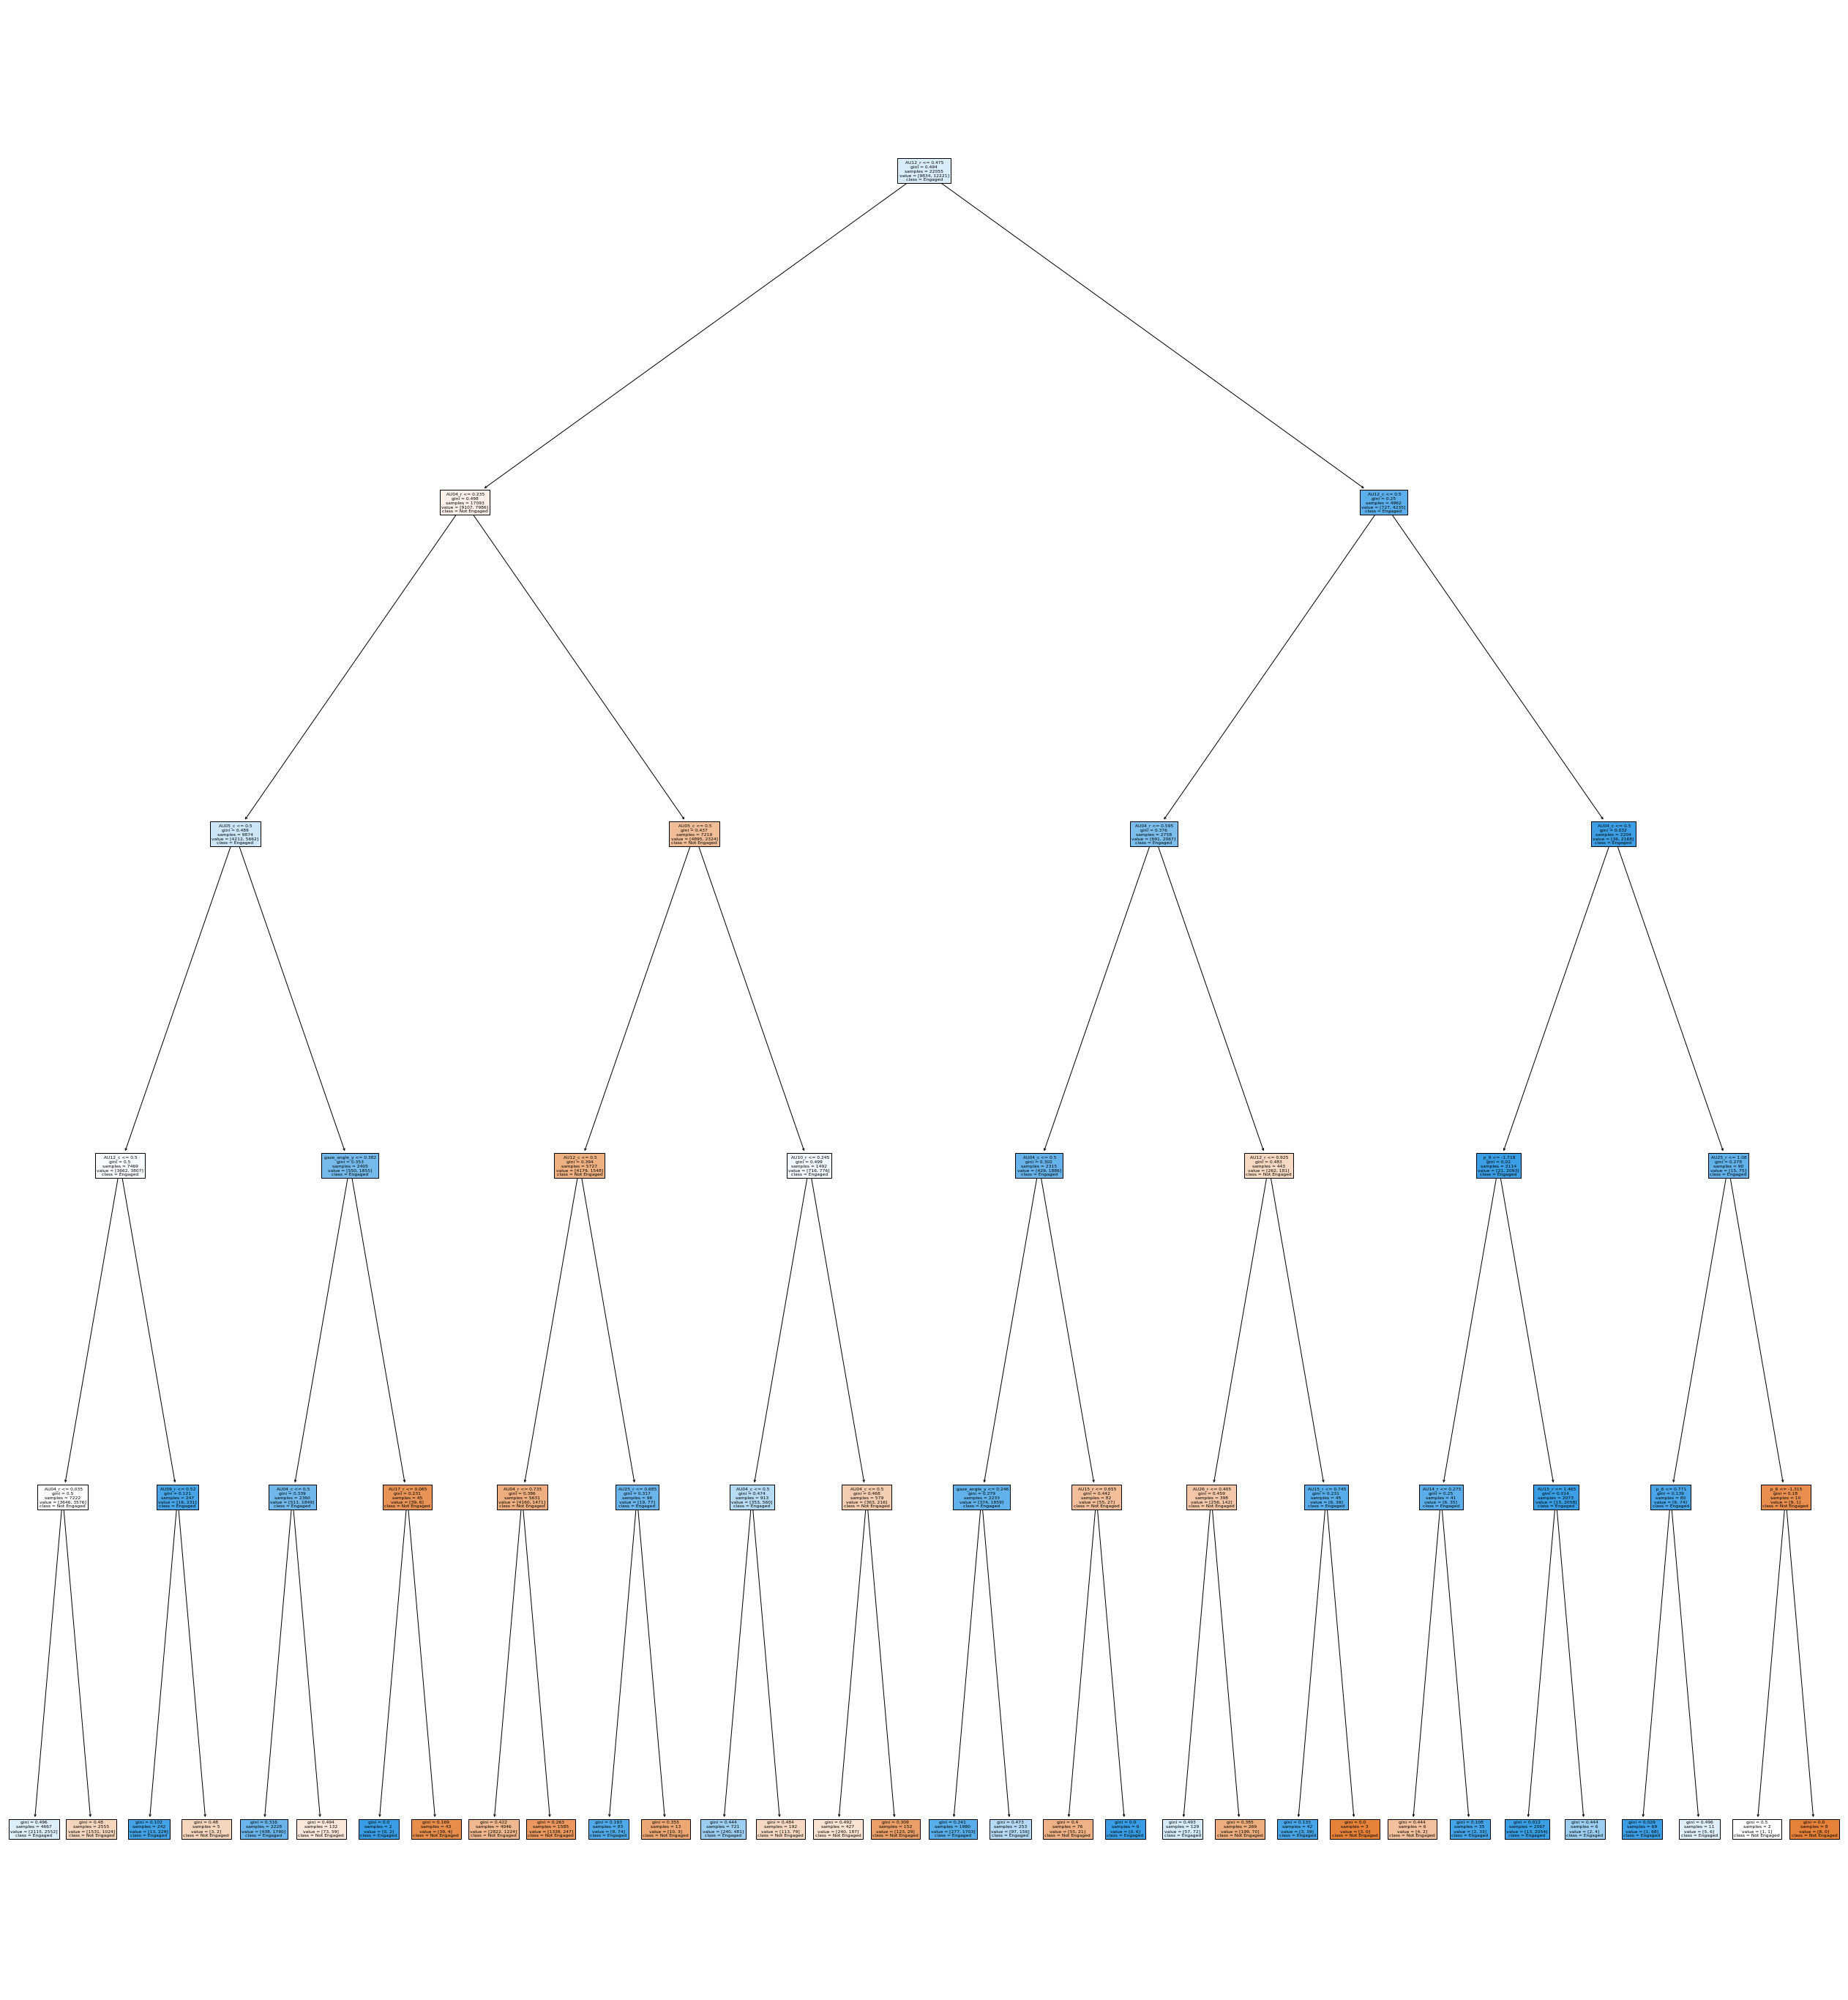

In [23]:
plt.figure(figsize=(45,50))
tree.plot_tree(model,filled=True,feature_names=feat,class_names=["Not Engaged","Engaged"])

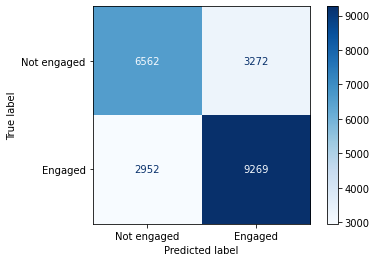

In [24]:
metrics.plot_confusion_matrix(model, x_train, y_train, cmap=plt.cm.Blues, display_labels=['Not engaged', 'Engaged'])

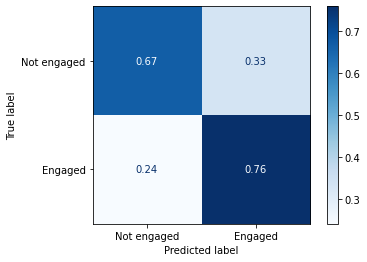

In [25]:
metrics.plot_confusion_matrix(model, x_train, y_train, cmap=plt.cm.Blues, display_labels=['Not engaged', 'Engaged'], normalize='true')